In [160]:
import random

Autograd: Automatic gradient -> implements backpropigation 

Backpropigation: Allows you to efficently evaluate the gradient some kind of a loss function with respect to the weights of a NN

Allows for us to iterativly tune the weights of the neural network to minimize the loss function and therefore improve the accuracy of the network


g.backward() -> Initalize backpropigation at node g

Recursilvy apply chain rule

Neural Networks just take input and weights and produce an output


Below IS MicroGrad step by step

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x +5

In [3]:
f(3.0)

20.0

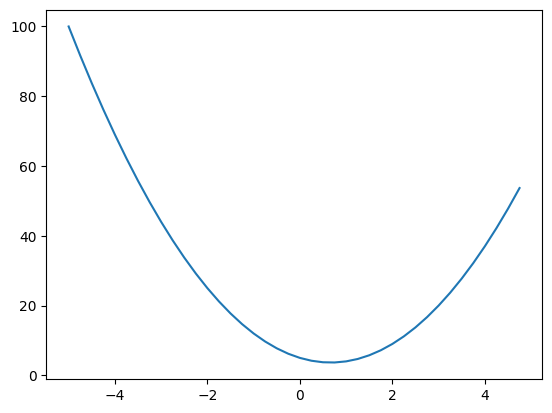

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
#At x=3 f(x) = 14
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

In [6]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [7]:
#Derivative of D with resepct to a b c
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
#D with respect to a
a += h #bumping a by h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

#Slope will be negative as we went down


d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [140]:
#Build out value object
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 
        self._backward = lambda: None #Will be a function , will do chain rule at each node that took inputs and produced output
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward(): 
            self.grad += 1.0 * out.grad # Chain rule 
            other.grad += 1.0 * out.grad 
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other): 
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other): # Other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self): #-self
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
            
        out._backward = _backward    

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad = out.data * out.grad 
        out._backward = _backward

        return out



    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()



In [131]:
a = Value(2.0)
b = Value(4.0)
a - b

value(data=-2.0)

In [26]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


dL / de = -2.0

e = a * b
de / da? b



want:
dL / da = (dL / de) * (de / da)


want:
dL / dc = (dL / dd) * (dd / dc) - chain rule

know:
dL / dd = -2.0
dd / dc = 

Forward pass: Output of forward pass = -8

Now Backpropigation 

Now we create a variable inside the Value class that maintains the derivative of L with respect of that value: we will call this value grad

What we did: we iterated through all the nodes one by one and locally applied the chain rule
we always know what is the derivative of L with resepct to output

Then we look at how this output was produced 
This output was produced through some operation and we have the pointers to the children nows of this operation

We know what the local derivatives are and we just multiply them onto the derivaitve always 
Go through and recursivly multiply on the local derivative and thats what backpropigation is !!

BACKPROPIGATION: A Recursive application of the chain rule , backwards through the graph


In [141]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Wegihts w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1#w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# N is now the cell body raw activation, without the activation function ( RELU, TANH ect )
#Output
o = n.tanh(); o.label = 'o' #TANH is a hyperbolic function
o.backward()

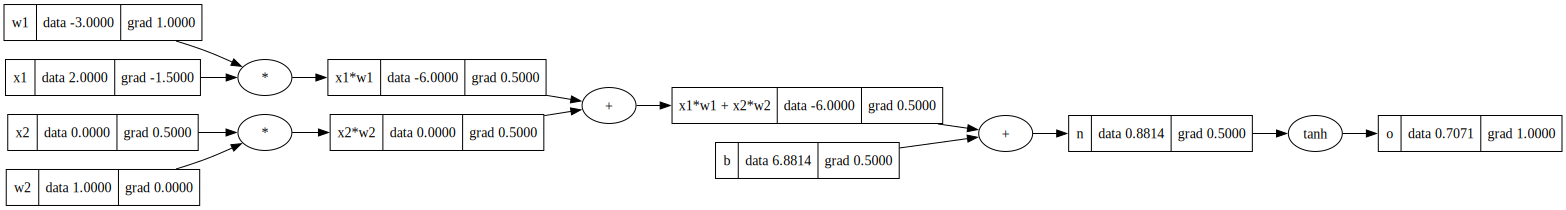

In [142]:
draw_dot(o)

tanh is now a micrograd supported tanh operation
as long as we know the derivative of tanh we can backpropigate through it


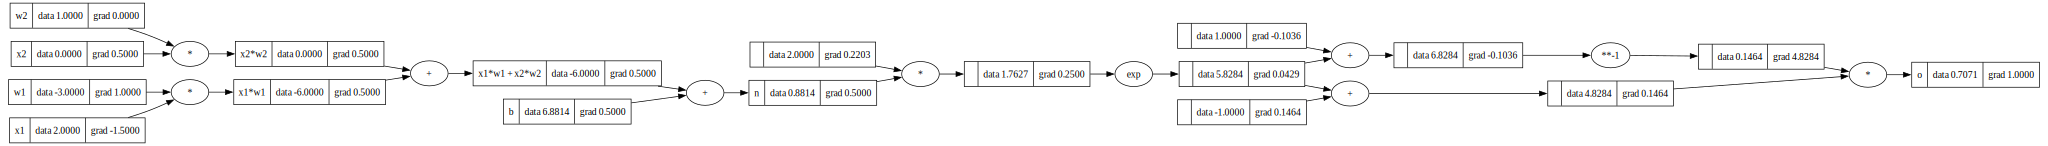

In [143]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Wegihts w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1#w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# N is now the cell body raw activation, without the activation function ( RELU, TANH ect )
#Output
# -----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----- 
o.label = 'o' #TANH is a hyperbolic function
o.backward()
draw_dot(o)

Now lets do the same in a modern framework such as PyTorch !! 

In PyTorch everythin is based around TENSORS ( tensors are just n-dimensional arrays of scalars)

In [144]:
import torch

In [147]:
torch.Tensor([[1,2,3],[4,5,6]])

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [149]:
torch.Tensor([[1,2,3],[4,5,6]]).shape

torch.Size([2, 3])

In [150]:
torch.Tensor([[1,2,3],[4,5,6]]).dtype

torch.float32

In [151]:
torch.Tensor([2.0])

tensor([2.])

In [153]:
torch.Tensor([2.0]).double().dtype

torch.float64

In [154]:


x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True #float64 from 32, PyTorch assumes they do not require gradients, need to require grad
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True

n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n) # Perform tanh, what we get back is a Tensor

print(o.data.item()) # .item takes a single tensor of one element and just returns that element stripping out the tensor 
o.backward()
# This will print the forward pass: Which is 0.707 
print('----')
print('x2', x2.grad.item()) # These will be the gradients 
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [157]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [158]:
x2.grad.item()

0.5000001283844369

In [197]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    


x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

value(data=0.9552948877273267)

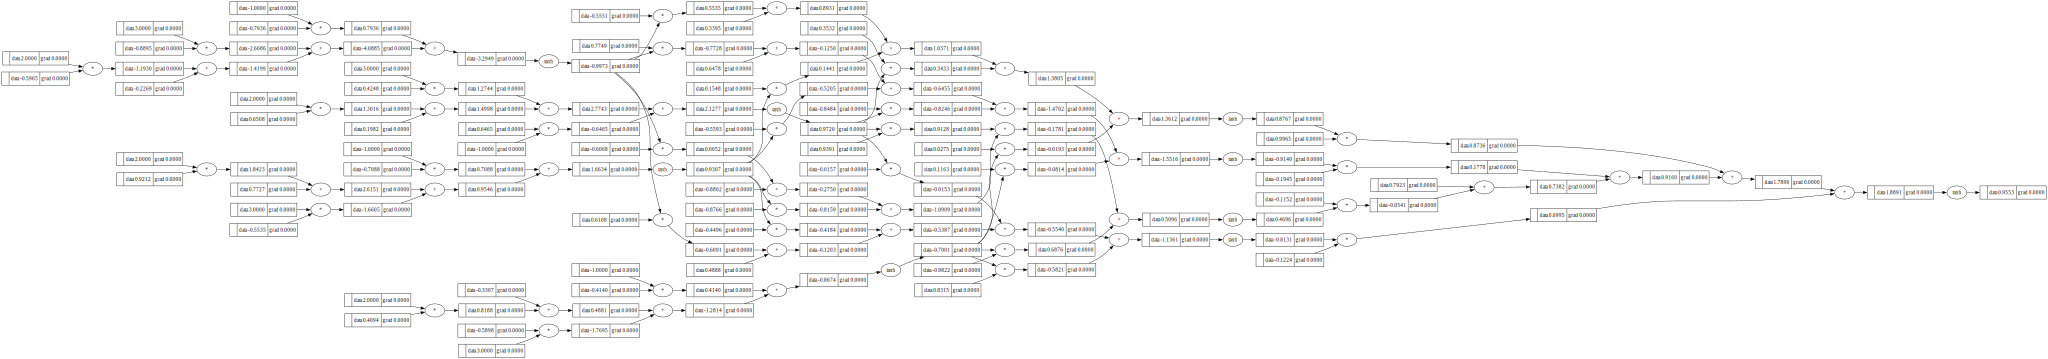

In [198]:
draw_dot(n(x))